In [1]:
import numpy as np
import pandas as pd

np.random.seed(0)

In [2]:
# # Load the store sales dataset
# excel_file = pd.ExcelFile('data/store_sales.xlsx')
# sheet_names = excel_file.sheet_names

# # Read the data
# results_df = pd.read_excel(excel_file, sheet_name=sheet_names[2])  # 2, 9
# iri_key_counts = results_df['IRI_KEY'].value_counts()
# iri_keys = iri_key_counts[iri_key_counts > 300].index


# features = ['F', 'D', 'Unit.Price']
# target = 'Total.Volume'

# results_df = results_df[results_df['IRI_KEY'] == iri_keys[0]]
# X = results_df[features].values
# y = results_df[target].values

# sheet_names, iri_keys, X.shape, y.shape

In [3]:
# Load the Boston dataset
data_url = 'http://lib.stat.cmu.edu/datasets/boston'
raw_df = pd.read_csv(data_url, sep='\s+', skiprows=22,  # type: ignore
                     header=None)  # type: ignore
X = np.hstack([raw_df.values[::2, :-1], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2].reshape(-1, 1).ravel()
X.shape, y.shape

((506, 12), (506,))

In [4]:
# # Load the California housing dataset
# from sklearn.datasets import fetch_california_housing
# housing = fetch_california_housing()
# X = housing.data  # type: ignore
# y = housing.target  # type: ignore
# X.shape, y.shape, housing.feature_names  # type: ignore

In [5]:
# # Load the soybean dataset
# raw_df = pd.read_excel("data/soybean.xlsx")
# # print(raw_df.head())
# X = raw_df.values[:-1, [5, 6, 15, 16, 17, 26,
#                         34, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]]  # 9 check yield 12 rm band
# y = raw_df.values[:-1, 11]
# X.shape, y.shape

In [6]:
from sklearn.preprocessing import StandardScaler

X = X.astype(np.float64)
y = y.astype(np.float64)

# scaler_X = StandardScaler()
# X = scaler_X.fit_transform(X)
# scaler_y = StandardScaler()
# y = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()  # type: ignore

In [7]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from models_sklearn import Ensemble, MLP, FONN1, FONN2, TREENN1, TREENN2
from models import MLP as MLP_2, FONN1 as FONN1_2, FONN2 as FONN2_2, TREENN1 as TREENN1_2, TREENN2 as TREENN2_2

search_params = {
    'scoring': ['neg_root_mean_squared_error', 'r2'],
    'n_jobs': -1,
    'refit': 'neg_root_mean_squared_error',
    'verbose': 1,
    'return_train_score': True
}

ensemble_param_grid = {
}

nn_param_grid = {
    # 'max_iter': [1000, 100, 2000],
    'max_iter': [1000],
    'learning_rate': ['constant'],
    # 'learning_rate': ['adaptive'],
    # 'learning_rate_init': [1e-1, 1e-2, 1e-3],
    'learning_rate_init': [1e1, 1e-2, 1e-3],
    # 'early_stopping': [False],
    'early_stopping': [True],
    # 'n_iter_no_change': [10000]
}


def search_strategy(model, param_grid=nn_param_grid, search_params=search_params):
    return GridSearchCV(model, param_grid, **search_params)
# search_strategy = RandomizedSearchCV


models = {}

num_trees_input = 5
num_trees_hidden = 5
hidden_nodes = [5]
# hidden_nodes = [5, 10, 40, 100]
# hidden_nodes = [(5,), (10,), (40,), (100,)]

models['Tree'] = search_strategy(Ensemble(1), ensemble_param_grid)
for hn in hidden_nodes:
    if isinstance(hn, tuple):
        models[f'Ensemble {sum(hn)}'] = search_strategy(
            Ensemble(sum(hn)))
        models[f'MLP {hn}'] = search_strategy(
            MLP(hn))
        models[f'FONN1 {num_trees_input} {hn}'] = search_strategy(
            FONN1(num_trees_input, (num_trees_input+hn[0], *hn[1:])))
        models[f'FONN2 {num_trees_hidden} {hn}'] = search_strategy(
            FONN2(num_trees_hidden, (*hn[:-1], num_trees_hidden+hn[-1])))
        models[f'TREENN1 {hn}'] = search_strategy(
            TREENN1((1+hn[0], *hn[1:])))
        models[f'TREENN2 {hn}'] = search_strategy(
            TREENN2((*hn[:-1], 1+hn[-1])))
    else:
        models[f'Ensemble {hn}'] = search_strategy(
            Ensemble(hn), ensemble_param_grid)
        models[f'MLP {hn}'] = search_strategy(
            MLP(hn))
        models[f'FONN1 {num_trees_input} {hn}'] = search_strategy(
            FONN1(num_trees_input, num_trees_input+hn))
        models[f'FONN2 {num_trees_hidden} {hn}'] = search_strategy(
            FONN2(hn, num_trees_hidden+hn))
        models[f'TREENN1 {hn}'] = search_strategy(
            TREENN1(1+hn))
        models[f'TREENN2 {hn}'] = search_strategy(
            TREENN2(1+hn))

nn_param_grid_2 = {
    'epochs': [200],
    # 'epochs': [100],
    # 'learning_rate': [1e1, 1e0, 1e-1, 1e-2],
    'learning_rate': [1e-2, 1e-3],
}

input_dim = X.shape[1]
output_dim = 1

for hn in hidden_nodes:
    models[f'MLP_2 {hn}'] = search_strategy(
        MLP_2(input_dim, hn, output_dim), nn_param_grid_2)
    models[f'FONN1_2 {num_trees_input} {hn}'] = search_strategy(
        FONN1_2(input_dim, hn, output_dim, num_trees_input), nn_param_grid_2)
    models[f'FONN2_2 {num_trees_hidden} {hn}'] = search_strategy(
        FONN2_2(input_dim, hn, output_dim, num_trees_hidden), nn_param_grid_2)
    # models[f'TREENN1_2 {hn}'] = search_strategy(
    #     TREENN1_2(input_dim, hn, output_dim), nn_param_grid_2)
    # models[f'TREENN2_2 {hn}'] = search_strategy(
    #     TREENN2_2(input_dim, hn, output_dim), nn_param_grid_2)
    models[f'TREENN1_2 {hn}'] = search_strategy(
        FONN1_2(input_dim, hn, output_dim, 1), nn_param_grid_2)
    models[f'TREENN2_2 {hn}'] = search_strategy(
        FONN2_2(input_dim, hn, output_dim, 1), nn_param_grid_2)
    # models['Tree-based Predictions (FONN2)'] = models['FONN2'].trees
    # models['Tree-based Predictions (TREENN2)'] = models['TREENN2'].trees

In [8]:
import sys
import os
from warnings import simplefilter
if not sys.warnoptions:
    simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

# Train and evaluate models
cv_results = {}
results = []

result_columns = [
    'mean_fit_time', 'mean_score_time', 'mean_train_neg_root_mean_squared_error', 'mean_test_neg_root_mean_squared_error', 'mean_train_r2', 'mean_test_r2', 'params'
]

for name, model in models.items():
    model.fit(X, y)
    result = model.cv_results_
    results.append({
        'model': name,
        **{col: result[col][model.best_index_] for col in result_columns if col in result}
    })
    cv_results[name] = result

results_df = pd.DataFrame(results)
results_df.set_index('model', inplace=True)
results_df

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits


,mean_fit_time,mean_score_time,mean_train_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_train_r2,mean_test_r2,params
model,,,,,,,
Tree,0.006931,0.002425,-2.967406,-6.508260,0.889752,0.134384,{}
Ensemble 5,0.026357,0.002290,-1.793774,-4.610954,0.960570,0.580954,{}
MLP 5,0.454630,0.001807,-6.044178,-7.628893,0.552242,-0.410197,"{'early_stopping': True, 'learning_rate': 'con..."
FONN1 5 5,0.355620,0.003582,-1.722340,-4.919401,0.963827,0.532398,"{'early_stopping': True, 'learning_rate': 'con..."
FONN2 5 5,1.211605,0.001611,-7.653265,-8.579077,0.287194,-0.376511,"{'early_stopping': True, 'learning_rate': 'con..."
TREENN1 5,1.171930,0.001411,-4.527821,-9.457461,0.710287,-3.598430,"{'early_stopping': True, 'learning_rate': 'con..."
TREENN2 5,0.190534,0.001443,-7.079901,-8.444889,0.351548,-0.460274,"{'early_stopping': True, 'learning_rate': 'con..."
MLP_2 5,0.261229,0.001454,-8.642249,-8.813723,0.100377,-0.348335,"{'epochs': 200, 'learning_rate': 0.01}"
FONN1_2 5 5,1.556387,0.001399,-8.160155,-8.571090,0.190255,-0.229393,"{'epochs': 200, 'learning_rate': 0.01}"


In [9]:
results_df.sort_values(by='mean_test_neg_root_mean_squared_error', ascending=False)

,mean_fit_time,mean_score_time,mean_train_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,mean_train_r2,mean_test_r2,params
model,,,,,,,
Ensemble 5,0.026357,0.002290,-1.793774,-4.610954,0.960570,0.580954,{}
FONN1 5 5,0.355620,0.003582,-1.722340,-4.919401,0.963827,0.532398,"{'early_stopping': True, 'learning_rate': 'con..."
Tree,0.006931,0.002425,-2.967406,-6.508260,0.889752,0.134384,{}
TREENN2_2 5,0.497094,0.001732,-2.464735,-6.604900,0.926492,0.035535,"{'epochs': 200, 'learning_rate': 0.01}"
MLP 5,0.454630,0.001807,-6.044178,-7.628893,0.552242,-0.410197,"{'early_stopping': True, 'learning_rate': 'con..."
FONN2_2 5 5,1.076483,0.002166,-2.922669,-7.701930,0.896357,-0.381166,"{'epochs': 200, 'learning_rate': 0.01}"
TREENN2 5,0.190534,0.001443,-7.079901,-8.444889,0.351548,-0.460274,"{'early_stopping': True, 'learning_rate': 'con..."
FONN1_2 5 5,1.556387,0.001399,-8.160155,-8.571090,0.190255,-0.229393,"{'epochs': 200, 'learning_rate': 0.01}"
FONN2 5 5,1.211605,0.001611,-7.653265,-8.579077,0.287194,-0.376511,"{'early_stopping': True, 'learning_rate': 'con..."


In [10]:
[(result['model'], result['params']) for result in results], cv_results

([('Tree', {}),
  ('Ensemble 5', {}),
  ('MLP 5',
   {'early_stopping': True,
    'learning_rate': 'constant',
    'learning_rate_init': 0.01,
    'max_iter': 1000}),
  ('FONN1 5 5',
   {'early_stopping': True,
    'learning_rate': 'constant',
    'learning_rate_init': 0.01,
    'max_iter': 1000}),
  ('FONN2 5 5',
   {'early_stopping': True,
    'learning_rate': 'constant',
    'learning_rate_init': 0.001,
    'max_iter': 1000}),
  ('TREENN1 5',
   {'early_stopping': True,
    'learning_rate': 'constant',
    'learning_rate_init': 0.001,
    'max_iter': 1000}),
  ('TREENN2 5',
   {'early_stopping': True,
    'learning_rate': 'constant',
    'learning_rate_init': 0.01,
    'max_iter': 1000}),
  ('MLP_2 5', {'epochs': 200, 'learning_rate': 0.01}),
  ('FONN1_2 5 5', {'epochs': 200, 'learning_rate': 0.01}),
  ('FONN2_2 5 5', {'epochs': 200, 'learning_rate': 0.01}),
  ('TREENN1_2 5', {'epochs': 200, 'learning_rate': 0.01}),
  ('TREENN2_2 5', {'epochs': 200, 'learning_rate': 0.01})],
 {'Tree

In [11]:
dataset_rank = results_df[['mean_test_neg_root_mean_squared_error']].rank(numeric_only=True, ascending=False)
dataset_rank = dataset_rank.assign(Mean=dataset_rank.mean(1), Stddev=dataset_rank.std(1))
dataset_rank

,mean_test_neg_root_mean_squared_error,Mean,Stddev
model,,,
Tree,3.0,3.0,NaN
Ensemble 5,1.0,1.0,NaN
MLP 5,5.0,5.0,NaN
FONN1 5 5,2.0,2.0,NaN
FONN2 5 5,9.0,9.0,NaN
TREENN1 5,12.0,12.0,NaN
TREENN2 5,7.0,7.0,NaN
MLP_2 5,10.0,10.0,NaN
FONN1_2 5 5,8.0,8.0,NaN


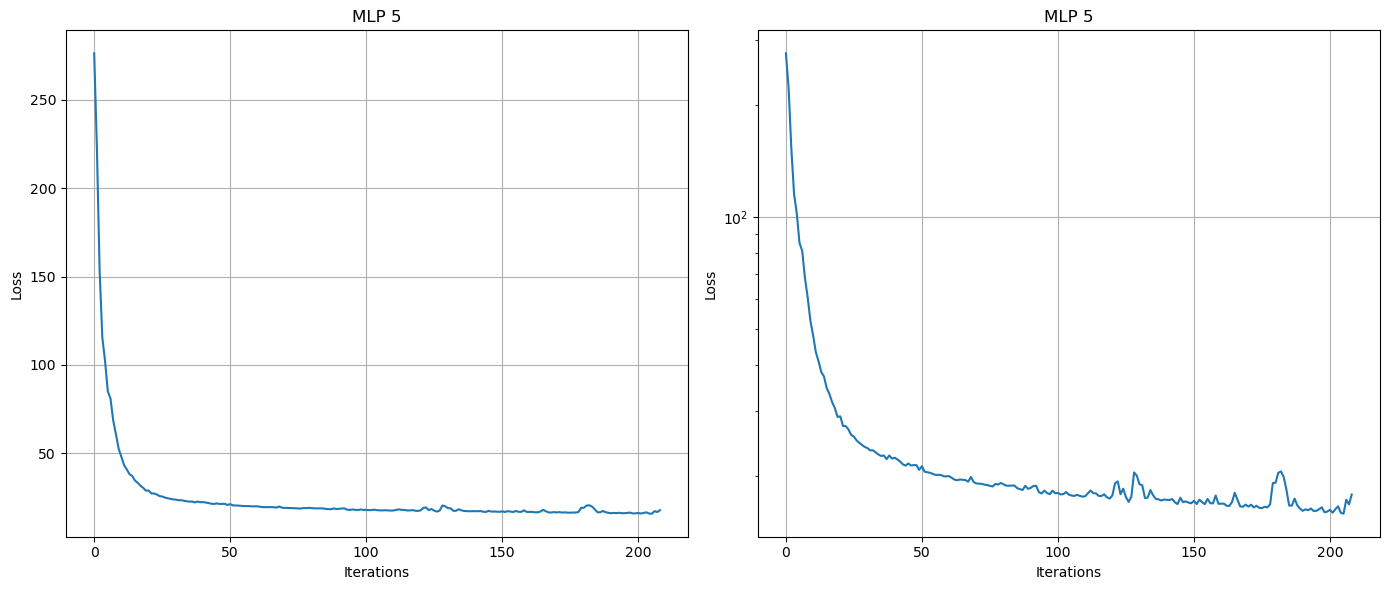

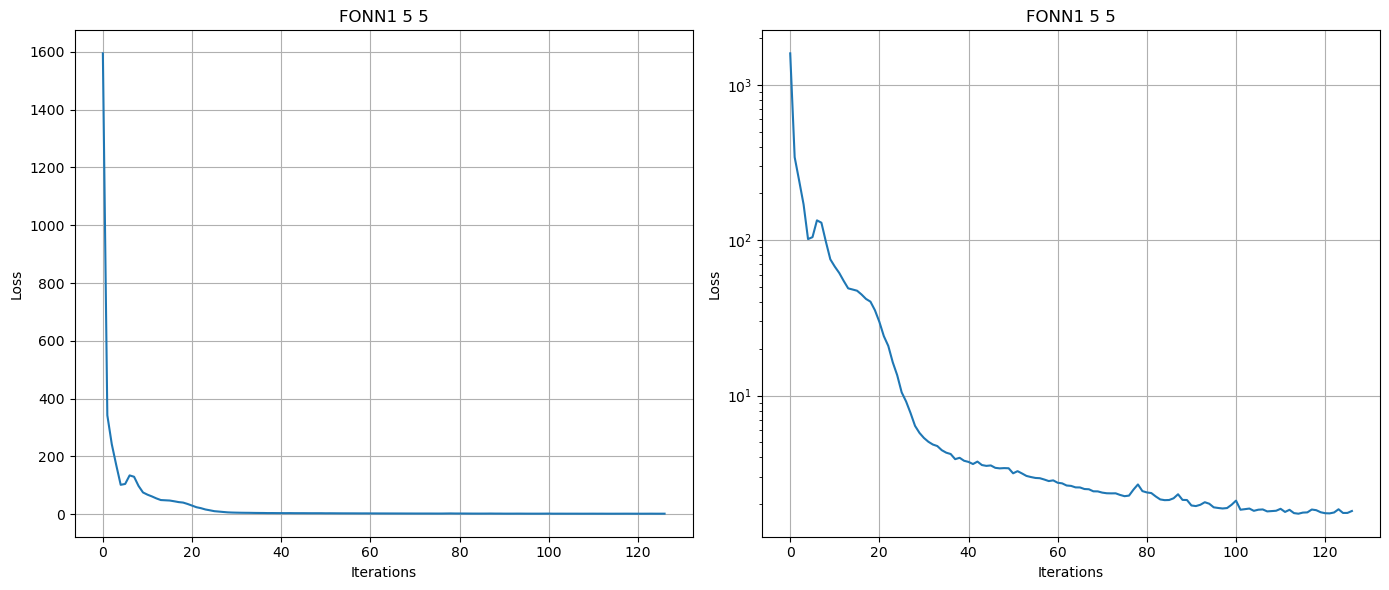

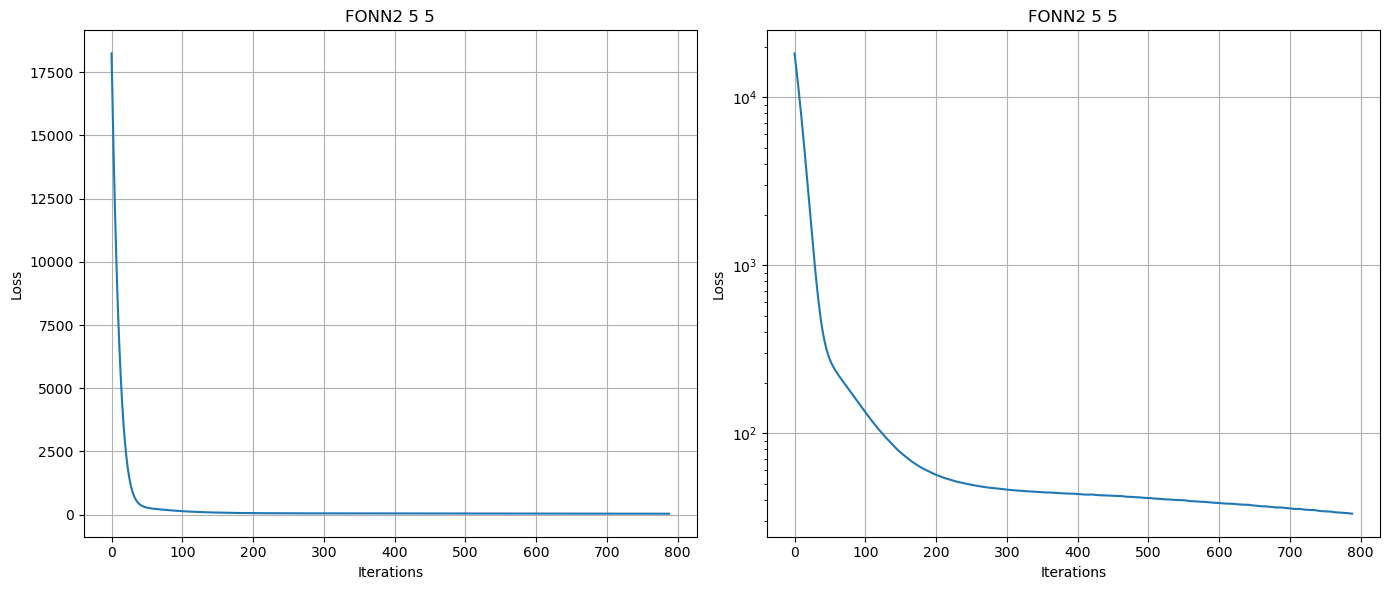

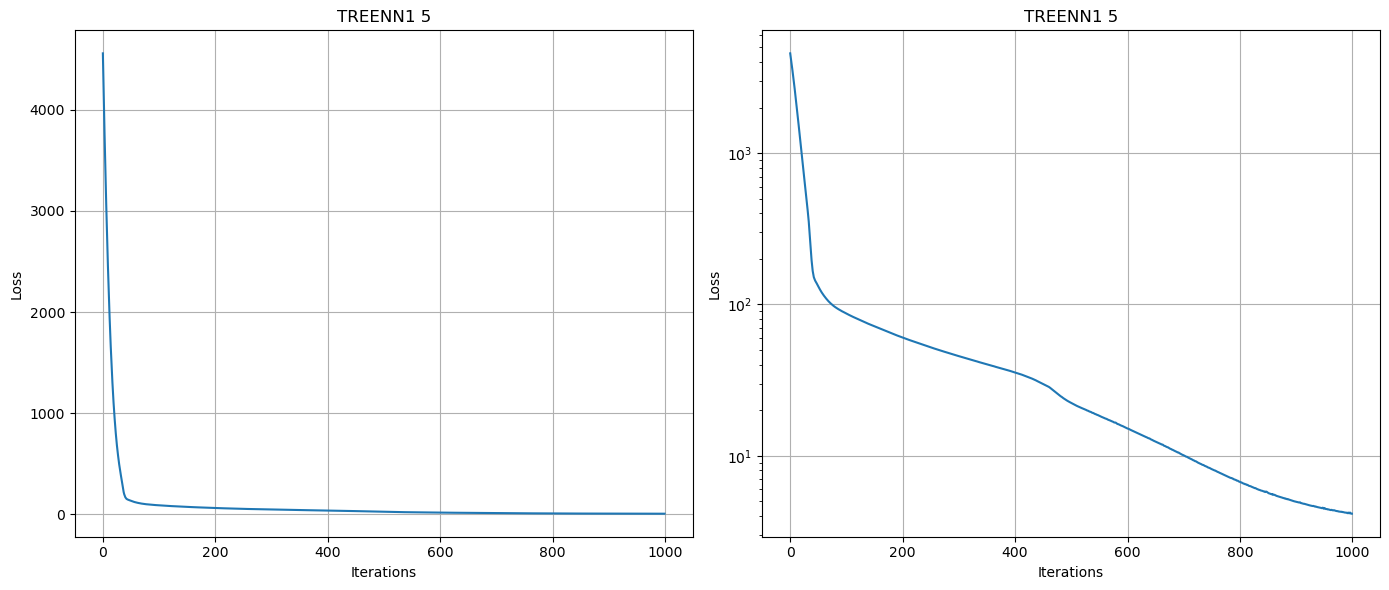

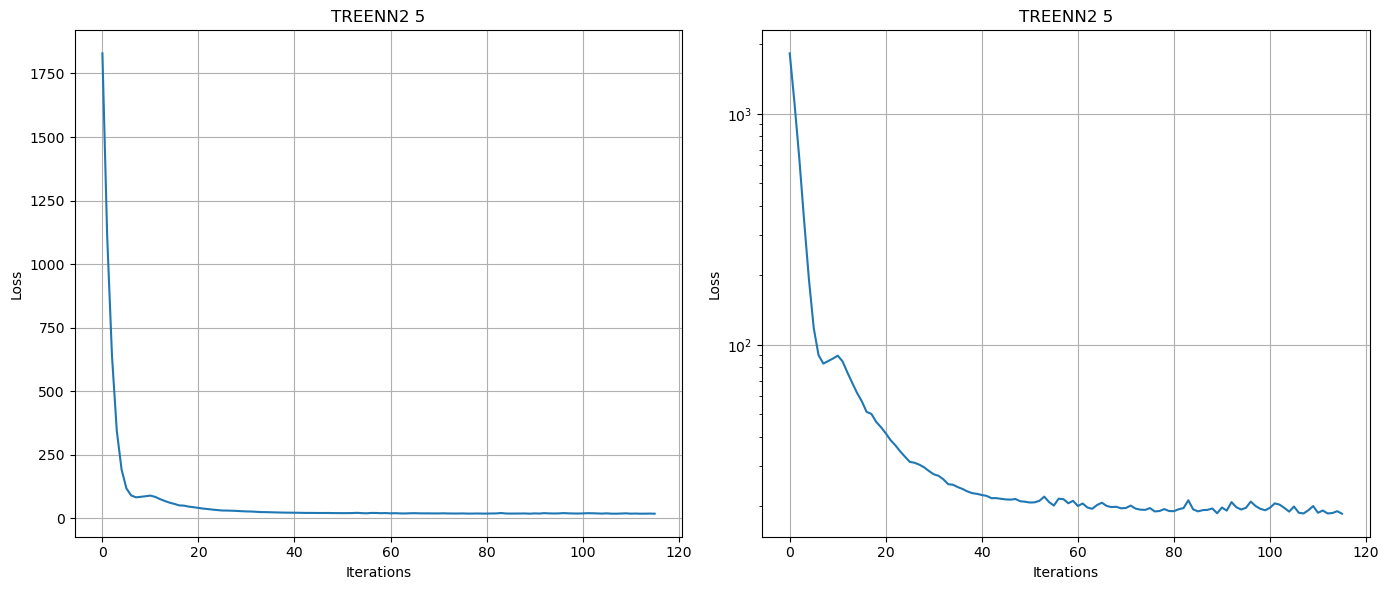

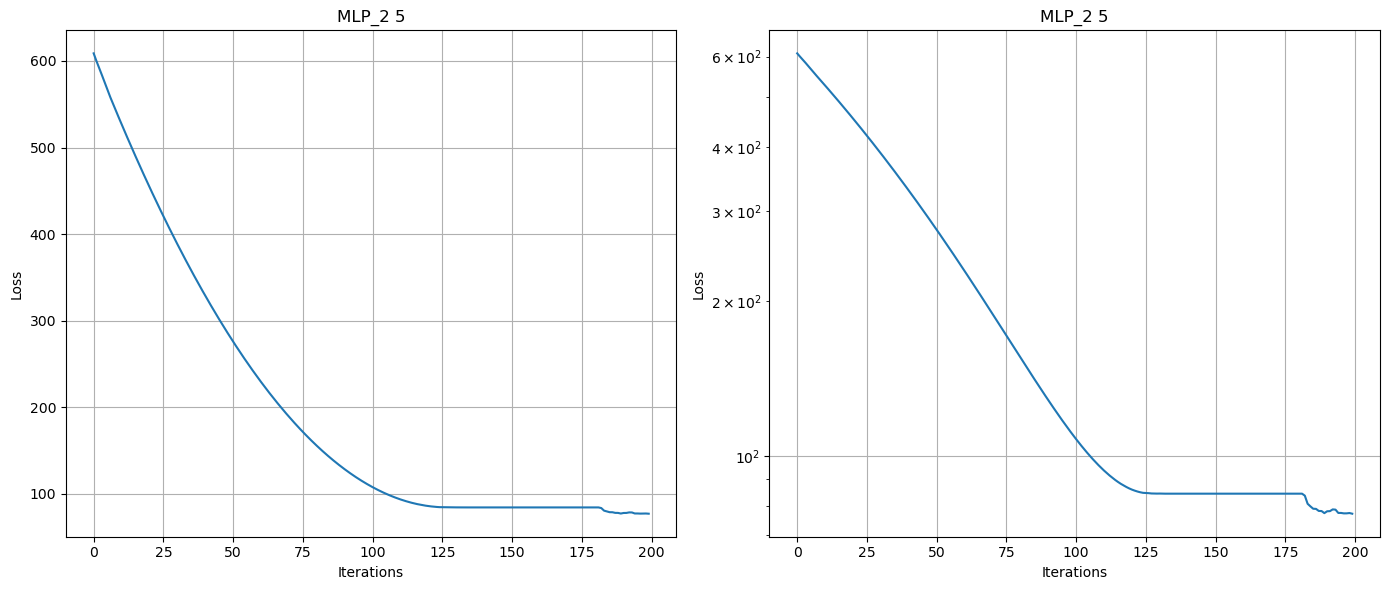

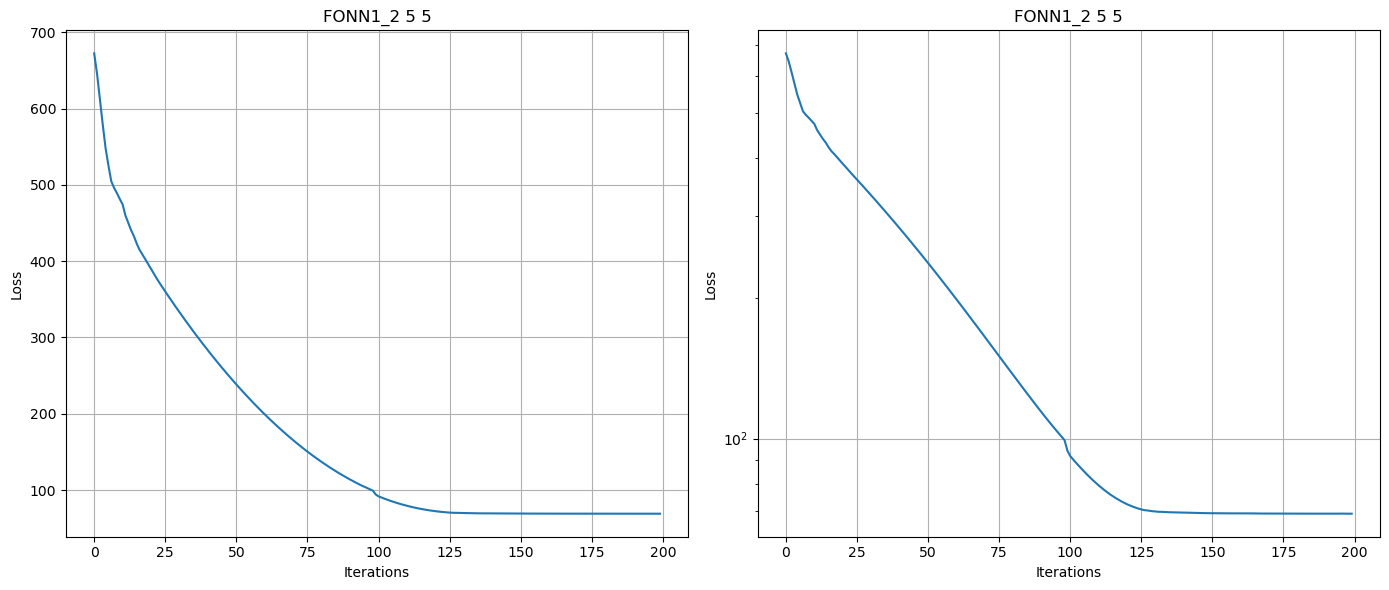

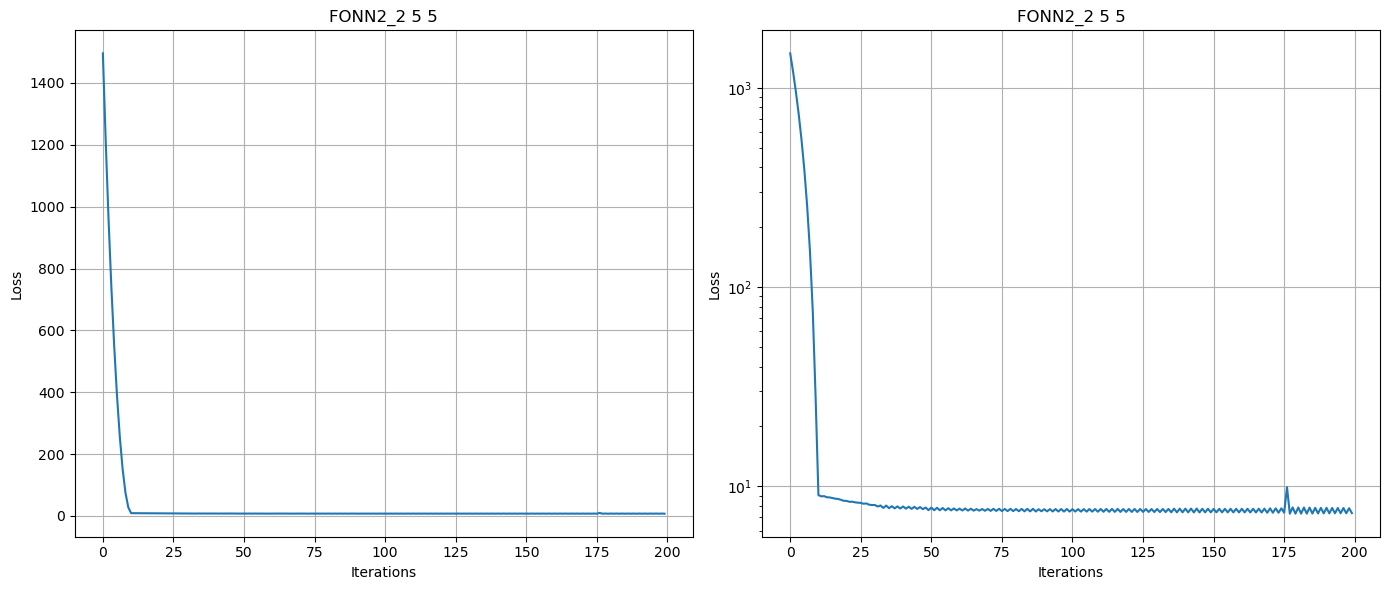

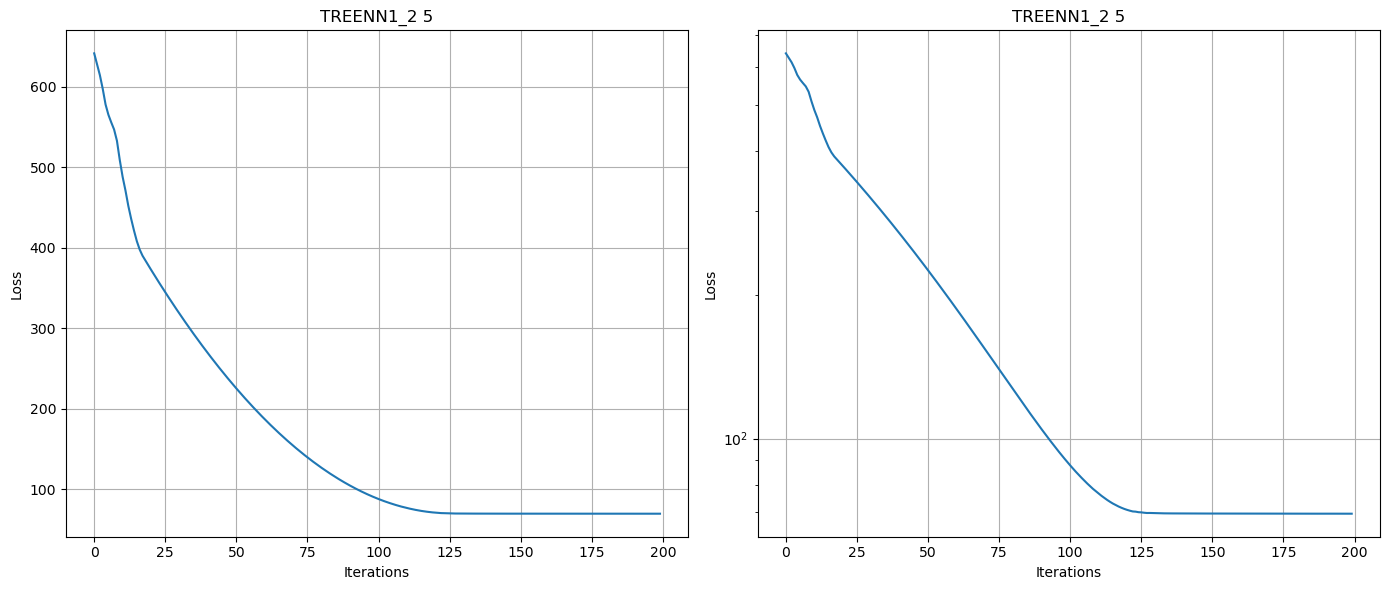

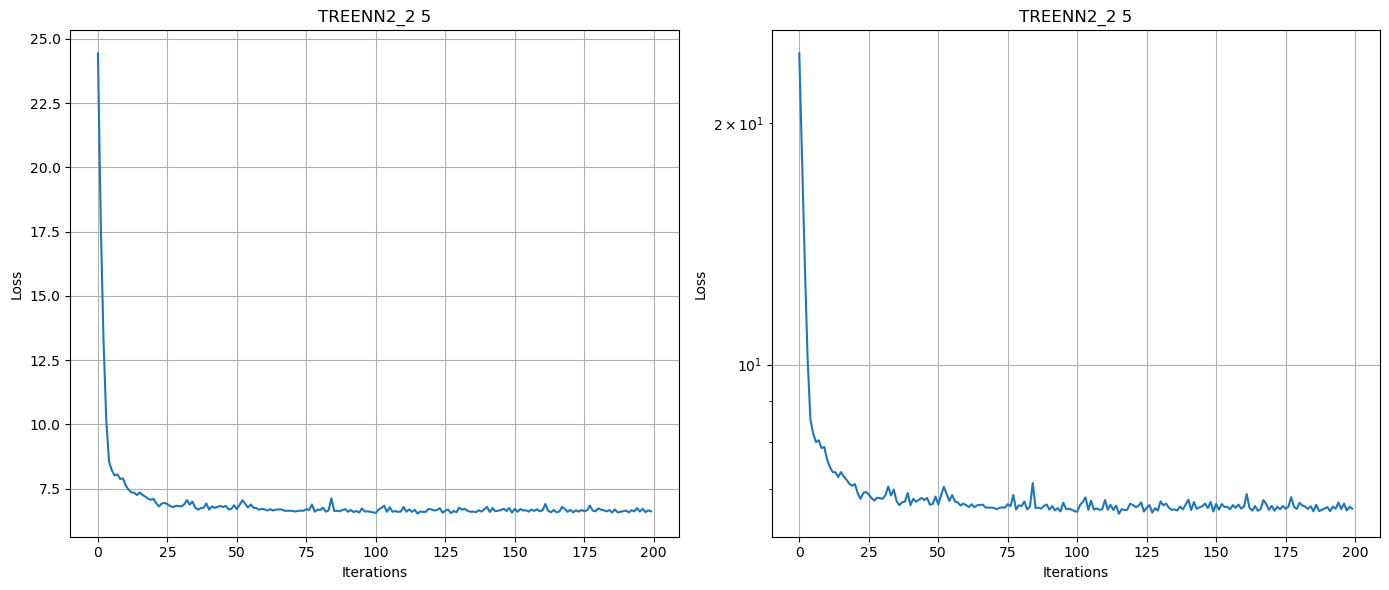

In [12]:
import matplotlib.pyplot as plt


def plot_loss(model, title='Loss Curve'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    ax1.plot(model.loss_curve_)
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')
    ax1.set_title(title)
    ax1.grid(True)

    ax2.plot(model.loss_curve_)
    ax2.set_yscale('log')
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Loss')
    ax2.set_title(title)
    ax2.grid(True)

    fig.tight_layout()
    fig.show()


for model_name, model in models.items():
    if hasattr(model.best_estimator_, 'loss_curve_'):
        plot_loss(model.best_estimator_, model_name)

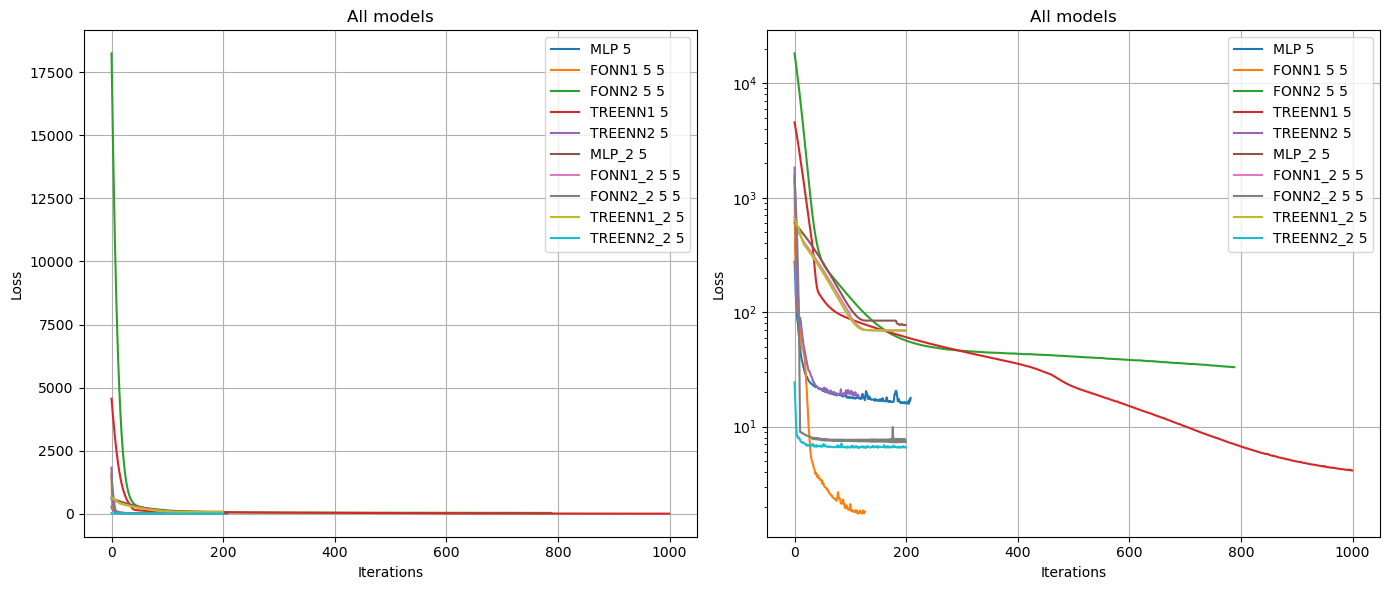

In [13]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for model_name, model in models.items():
    if hasattr(model.best_estimator_, 'loss_curve_'):
        ax1.plot(model.best_estimator_.loss_curve_, label=model_name)
        ax2.plot(model.best_estimator_.loss_curve_, label=model_name)

ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.set_title('All models')
ax1.legend()
ax1.grid(True)

ax2.set_yscale('log')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Loss')
ax2.set_title('All models')
ax2.legend()
ax2.grid(True)

fig.tight_layout()
fig.show()

{'MLP': (<Figure size 1400x600 with 2 Axes>,
  array([<Axes: title={'center': 'MLP'}, xlabel='Iterations', ylabel='Loss'>,
         <Axes: title={'center': 'MLP'}, xlabel='Iterations', ylabel='Loss'>],
        dtype=object)),
 'FONN1': (<Figure size 1400x600 with 2 Axes>,
  array([<Axes: title={'center': 'FONN1'}, xlabel='Iterations', ylabel='Loss'>,
         <Axes: title={'center': 'FONN1'}, xlabel='Iterations', ylabel='Loss'>],
        dtype=object)),
 'FONN2': (<Figure size 1400x600 with 2 Axes>,
  array([<Axes: title={'center': 'FONN2'}, xlabel='Iterations', ylabel='Loss'>,
         <Axes: title={'center': 'FONN2'}, xlabel='Iterations', ylabel='Loss'>],
        dtype=object)),
 'TREENN1': (<Figure size 1400x600 with 2 Axes>,
  array([<Axes: title={'center': 'TREENN1'}, xlabel='Iterations', ylabel='Loss'>,
         <Axes: title={'center': 'TREENN1'}, xlabel='Iterations', ylabel='Loss'>],
        dtype=object)),
 'TREENN2': (<Figure size 1400x600 with 2 Axes>,
  array([<Axes: title={

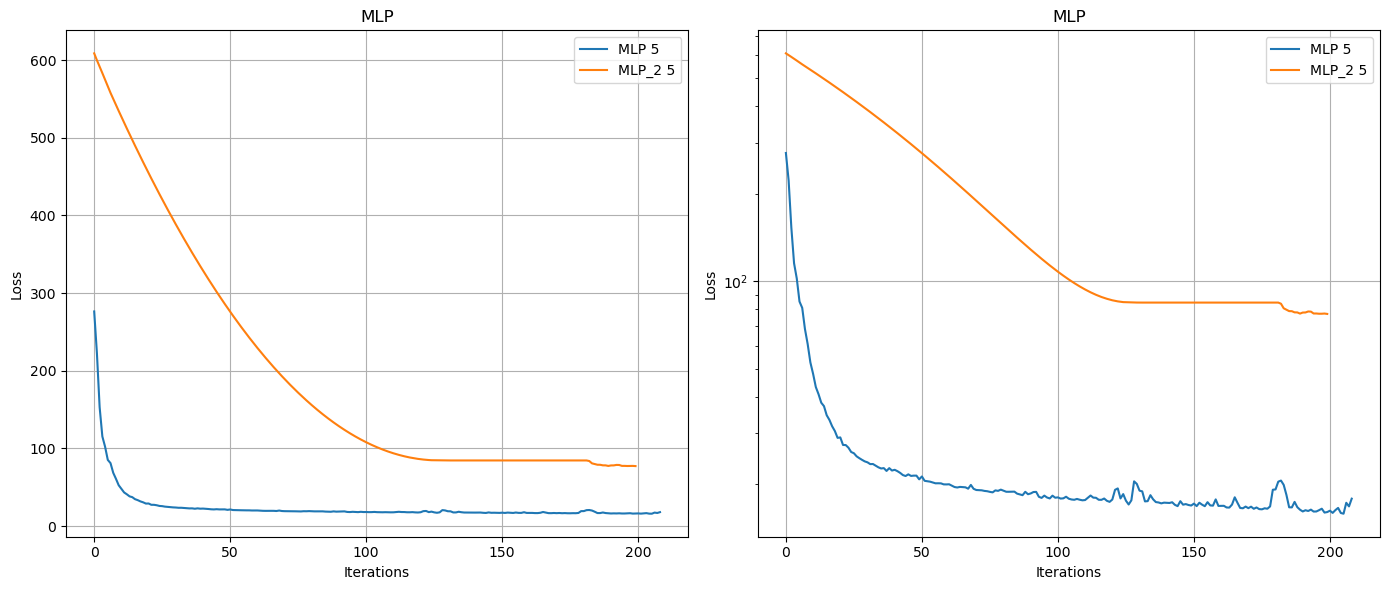

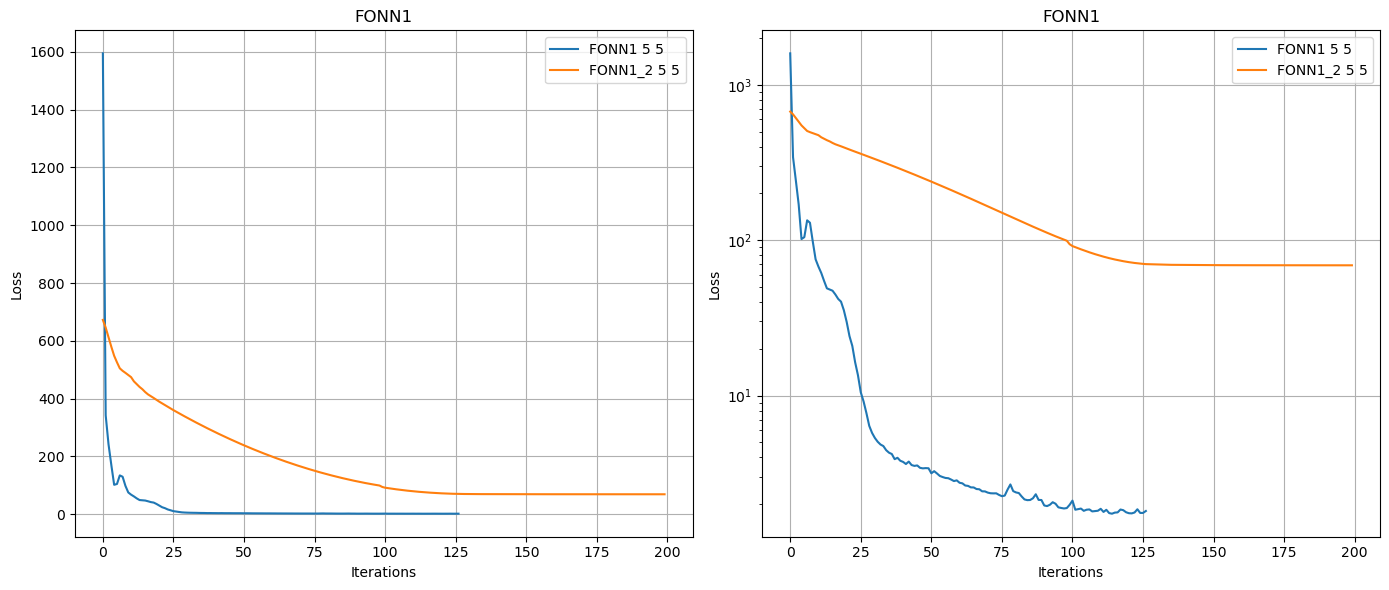

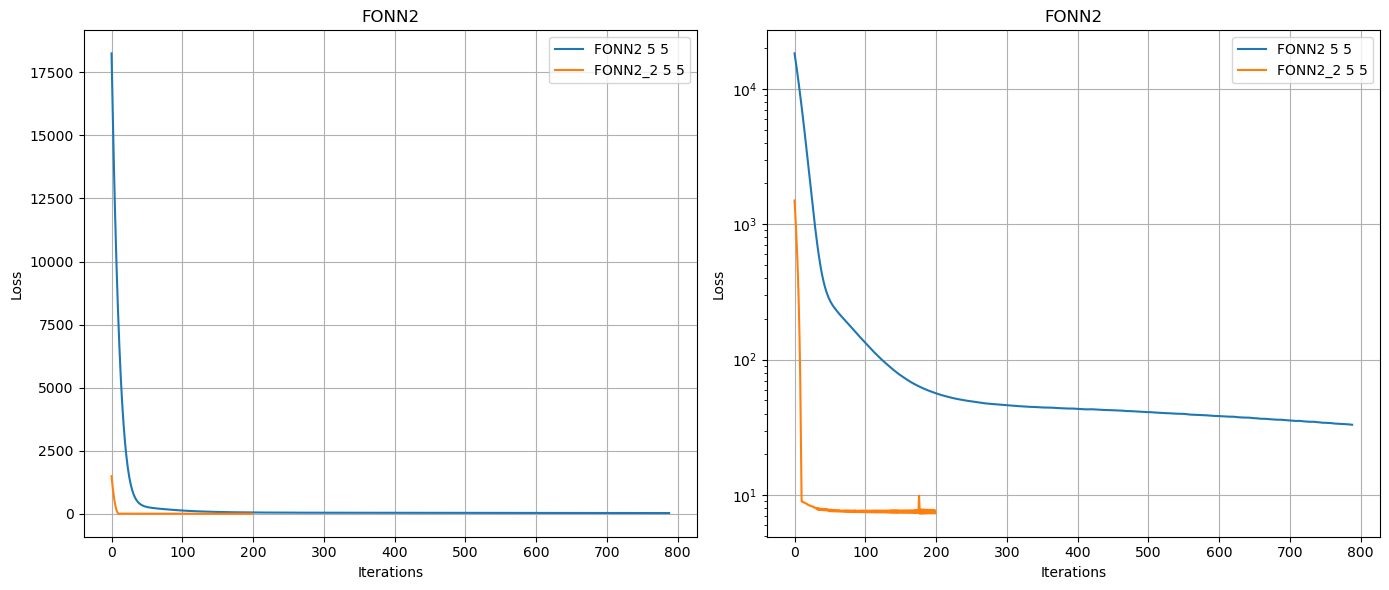

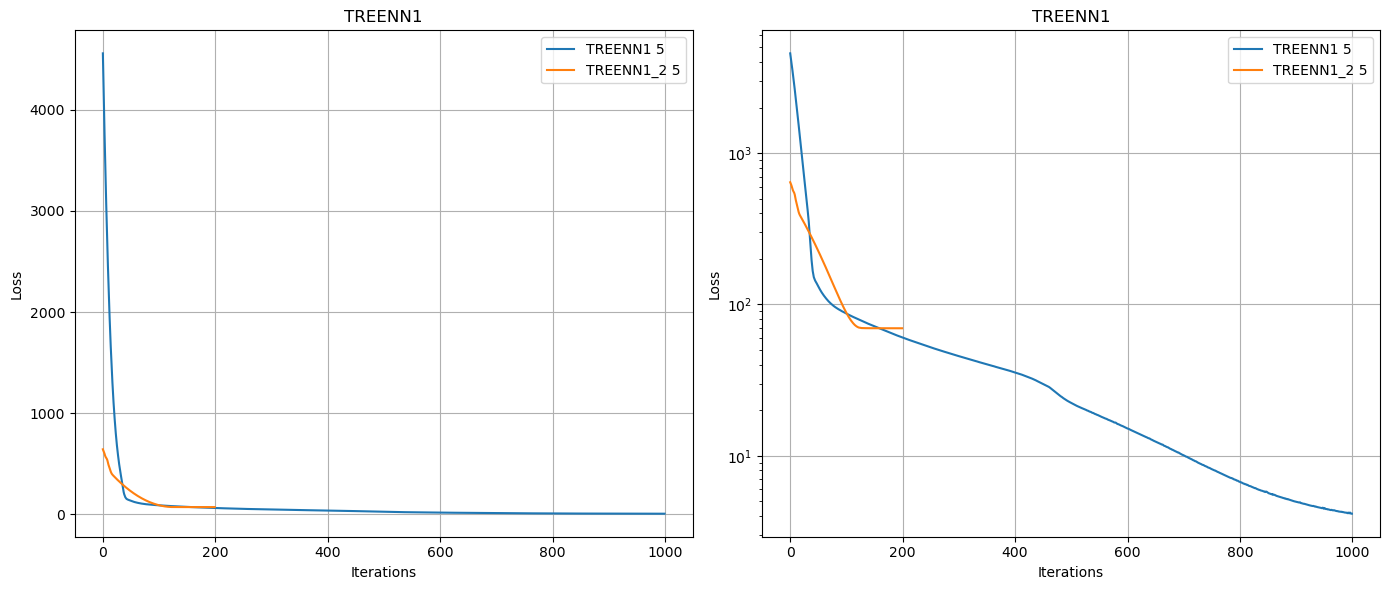

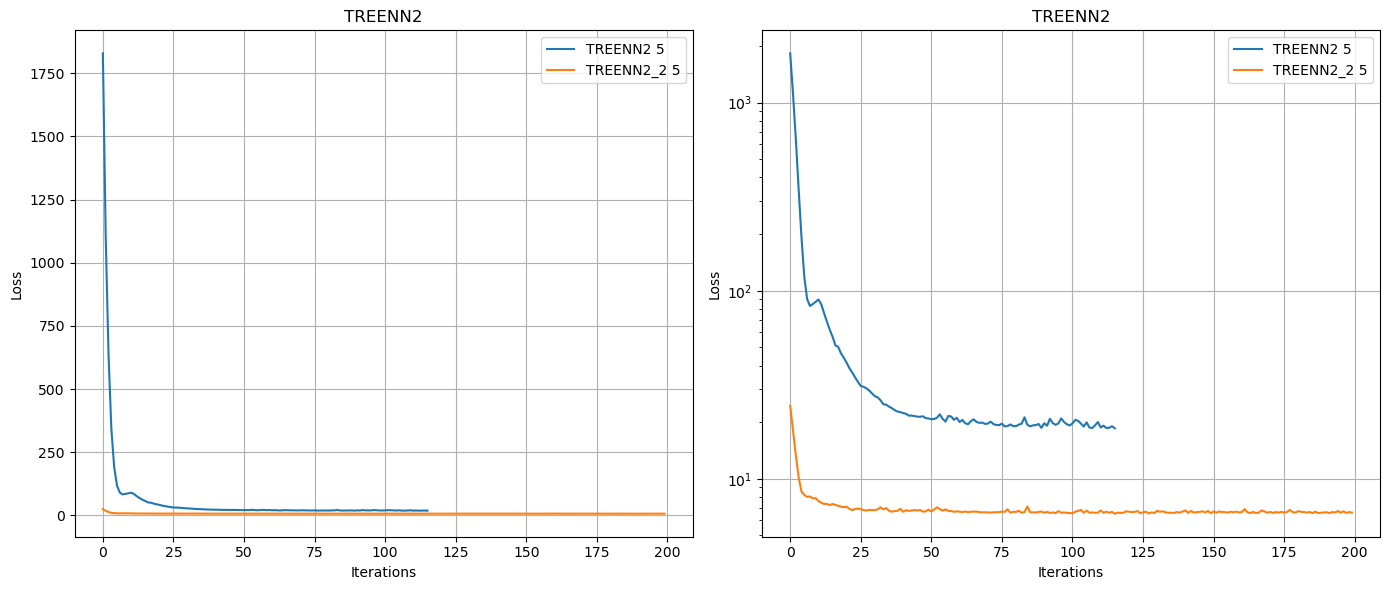

In [14]:
import matplotlib.pyplot as plt

plot_groups = {}
for model_name, model in models.items():
    if hasattr(model.best_estimator_, 'loss_curve_'):
        key = model_name.split('_' if '_' in model_name else ' ')[0]
        if key not in plot_groups:
            plot_groups[key] = plt.subplots(1, 2, figsize=(14, 6))
        fig, (ax1, ax2) = plot_groups[key]
        ax1.plot(model.best_estimator_.loss_curve_, label=model_name)
        ax2.plot(model.best_estimator_.loss_curve_, label=model_name)

for group, plot in plot_groups.items():
    fig, (ax1, ax2) = plot
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')
    ax1.set_title(group)
    ax1.legend()
    ax1.grid(True)

    ax2.set_yscale('log')
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Loss')
    ax2.set_title(group)
    ax2.legend()
    ax2.grid(True)

    fig.tight_layout()
    fig.show()
plot_groups